

**Objective:** 

A microservice that can accept a Document, and return an object describing the contents of that Document. The microservice should initially contain an endpoint to receive a PDF or Image containing a Bill of Lading Document, and return a description of the contents of that Document - and a check in the Bill of Lading database, hosted on Fawaris, for that document's validity.

The microservice should be extendible, with the aim to implement other Documents types in the future (eg. invoices, terms sheets, company accounts etc).


Scan to collect the following information:

* Vessel name/number
* Shipper
* Consignee
* Onward Shipping
* Port of Origin
* Port of Destination
* Cargo product
* Cargo weight
* Delivery address
* Shipper address

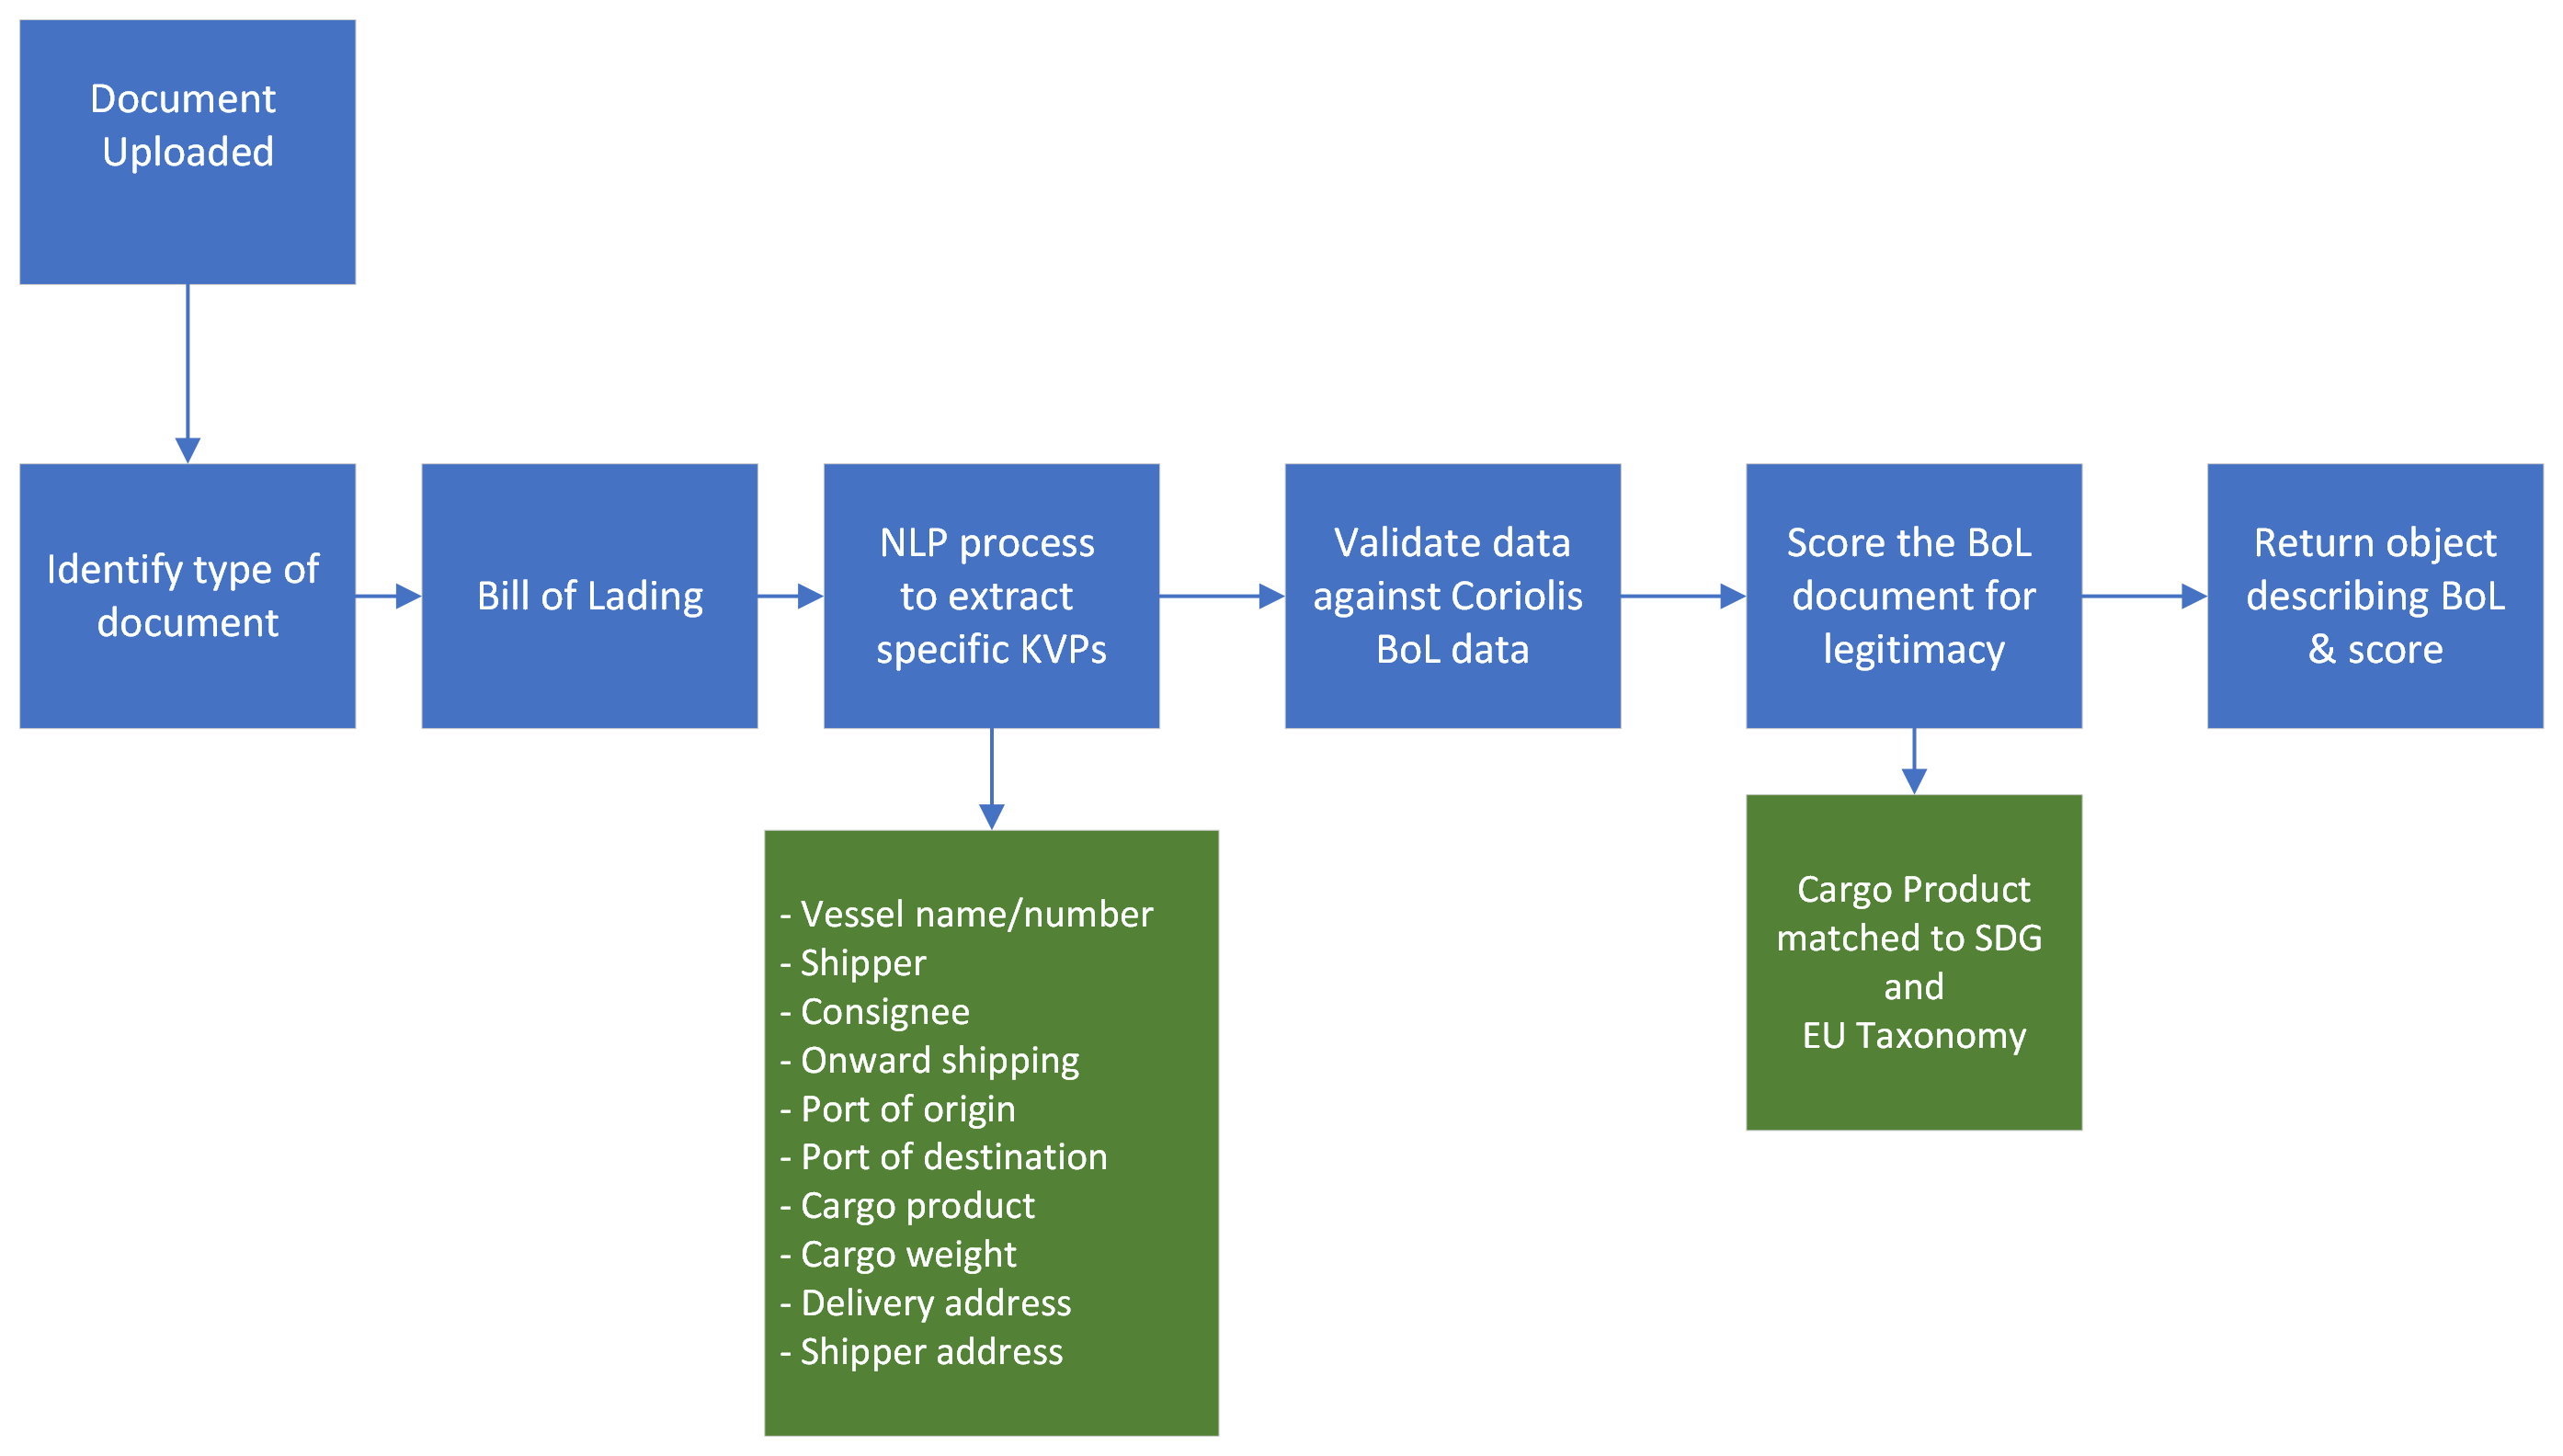

In [2]:
from IPython.display import Image
Image(filename = 'data/flow_chart.png')

# 1 **Problem Definition:** 

To retreive keyvalue pairs from uploaded files, which can be a pdf file or image or a pdf containing image. Theses files are bill of lading.

Keys can be:

* Vessel name/number
* Shipper
* Consignee
* Onward Shipping
* Port of Origin
* Port of Destination
* Cargo product
* Cargo weight
* Delivery address
* Shipper address

However, there are many synonyms and abbreviation of these keys in the Bill of Ladings from different countries, and these BoLs can be in different formate and forms. The microservice should come up with these potential issues.

# 2 Import Libraries

In [3]:
#Libraries for pdf conversion
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
import re
from io import StringIO

#Libraries for feature extraction and topic modeling
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
#from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
#Other libraries
import numpy as np
import pandas as pd

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

import cv2
import filetype
import pytesseract
from pdf2image import convert_from_path
from PIL import Image

# Import PyTorch Library
import torch
from torch import nn

# Import external libraries
import argparse
#import opencv_wrapper as cvw
from skimage.filters import threshold_local
import json
import random
from string import ascii_uppercase, digits, punctuation
import colorama
import regex


import timeit

# 3 Image Preparation

Build a functin `Recognize_File_Type` to recognize the uploaded file. Input is file path and output is its format.

In [4]:
pwd

'/home/jason/Atlas/NTFP_1118'

In [5]:

# Recognize uploaded file type
file_path = 'data/11950 BL 02.pdf'

def Recognize_File_Type(file_path):    
    kind = filetype.guess(file_path)    
    if kind is None:        
        print('Cannot recognize file type!')        
        return    
    print('File extension: %s' % kind.extension)    
    print('File MIME type: %s' % kind.mime)

Recognize_File_Type(file_path)

File extension: pdf
File MIME type: application/pdf


Define a function `Convert_Pdf_to_Images` to convert pdf files to images. 
The benefit of this is that some .pdf files may contain images which cause failure to extract characters from them. 
Therefore, convert all uploaded files to images. 

This function contains an embeding fucntion `convert_from_path` from exiting library `pdf2image`

In [6]:
def Convert_Pdf_to_Images(path):
    '''input: file path
       output: image file and its name
    '''
    images = convert_from_path(path)
    for index, image in enumerate(images):      # iterate over different pages
        image.save(f'{path}-{index}.png')       # save image
        im = Image.open(f'{path}-{index}.png')  # open image
    return im

This is a pdf file and will be transfer to image
CPU times: user 613 ms, sys: 39.6 ms, total: 653 ms
Wall time: 843 ms


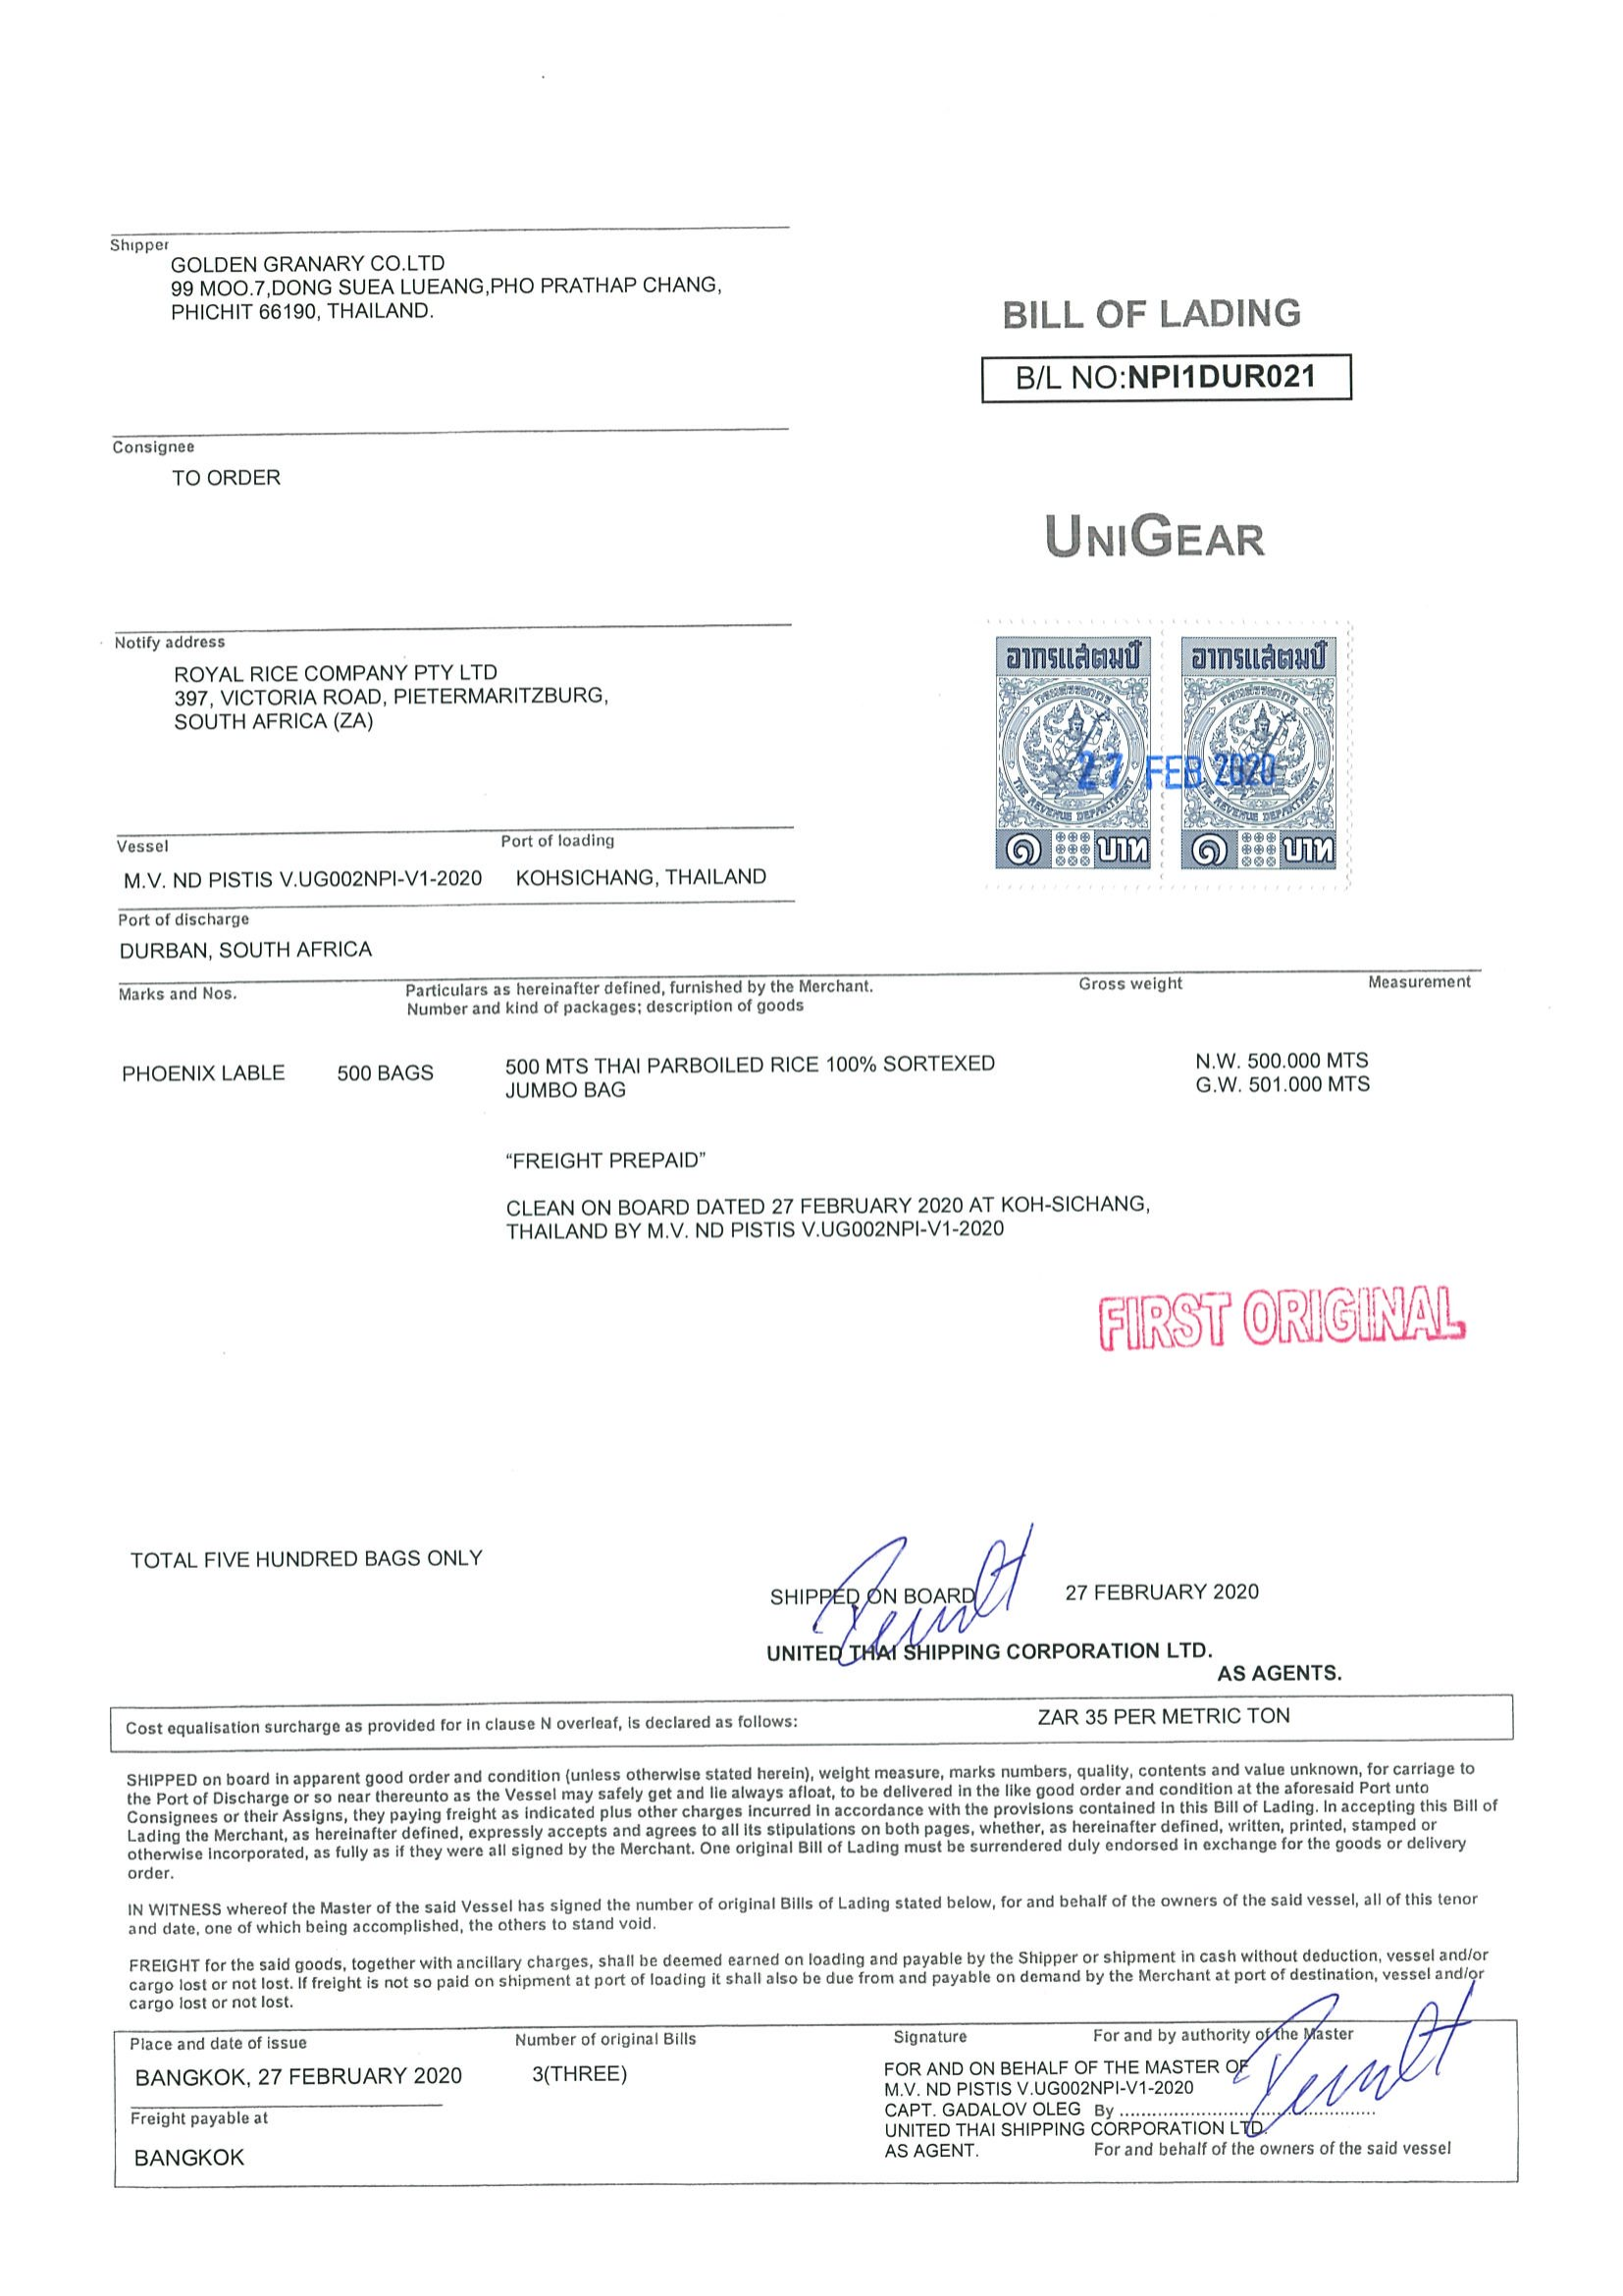

In [7]:
%%time
# define a funtion to recognize the uploaded file type, 
# convert to image if it is pdf, and 
# remain the same format and display it if is an image

def File_Recognition_2_Image(file_path):
    kind = filetype.guess(file_path).extension
    if kind == 'pdf':
        im = Convert_Pdf_to_Images(file_path)
        print ('This is a pdf file and will be transfer to image')

    if kind == 'png' or kind == 'jpg':
        print ('This is an image file')
    
    return im
  
im = File_Recognition_2_Image(file_path)    
im

# 4 Convert Image to text

After converting uploaded file to image, the next step is to extract characters by using existing Library `pytesseract`

Python-tesseract is a wrapper for **Google’s Tesseract-OCR Engine**. It is also useful as a stand-alone invocation script to tesseract, as it can read all image types supported by the Pillow and Leptonica imaging libraries, including jpeg, png, gif, bmp, tiff, and others. Additionally, if used as a script, Python-tesseract will print the recognized text instead of writing it to a file.

install tesserate on windows https://github.com/UB-Mannheim/tesseract/wiki

In [8]:
%%time
# convert image to text
extracted_text = pytesseract.image_to_string(im, lang = 'eng')
extracted_text # display the first 800 characters

CPU times: user 593 ms, sys: 10.5 ms, total: 603 ms
Wall time: 3.08 s


' \n\nShipper\nGOLDEN GRANARY CO.LTD\n99 MOO.7,DONG SUEA LUEANG,PHO PRATHAP CHANG,\n\nPHICHIT 66190, THAILAND. BILL OF LADING\nB/L NO:NPI1DUR021\n\n \n\nConsignee\nTO ORDER\n\nUniGEAR\n\n \n\nNotify address\nROYAL RICE COMPANY PTY LTD\n\n397, VICTORIA ROAD, PIETERMARITZBURG,\nSOUTH AFRICA (ZA)\n\n \n\n \n\nVessel Port of loading\nM.V. ND PISTIS V.UGOO2NPI-V1-2020 | KOHSICHANG, THAILAND\n\nPort of discharge\nDURBAN, SOUTH AFRICA\n\n \n\n \n\n \n\nMarks and Nos. Particulars as hereinafter defined, furnished by the Merchant, Gross weight Measurement\nNumber and kind of packages; description of goods\n\nPHOENIX LABLE 500 BAGS 500 MTS THAI PARBOILED RICE 100% SORTEXED N.W. 500.000 MTS\nJUMBO BAG G.W. 501.000 MTS\n“FREIGHT PREPAID”\n\nCLEAN ON BOARD DATED 27 FEBRUARY 2020 AT KOH-SICHANG,\n\nTHAILAND BY M.V. ND PISTIS V.UGOO2NPI-V1-2020\nFRIST ORCL\n\nTOTAL FIVE HUNDRED BAGS ONLY\n27 FEBRUARY 2020\n\n  \n\nUNITE IPPING CORPORATION LTD.\nAS AGENTS.\n\n \n\n \n\nCost equalisation surcharge as p

**Note:** By examing the output above, all keys and values have been extracted successfully except for the hand writing signiture. And it takes about 3 seconds to extract text from image.

There are five main OCR products

* ABBYY FineReader
* Amazon Textract
* Google Cloud Platform Vision API
* Microsoft Azure Computer Vision API
* Tesseract OCR Engine

This task use Tesseract OCR Engine.

This<td><a target="_blank" href="https://research.aimultiple.com/ocr-accuracy/"> chart</a> <td> 🤗 indicates the accuracy of different OCR engines in different applications. 


<img src="https://research.aimultiple.com/wp-content/uploads/2021/05/Overall_1.png"  />

* Category 1 – Web page screenshots that include texts: This category includes screenshots from random Wikipedia pages and Google search results with random queries.
* Category 2 – Handwriting: This category includes random photos that include different handwriting styles.
* Category 3 – Receipts, invoices, and scanned contracts: This category includes a random collection of receipts, handwritten invoices, and scanned insurance contracts collected from the internet.

In addition, there are some open resources to improve OCR performance, here is some related links, and I will have further research aiming to improve OCR performance for this specifict task since the Bill of Lading often contains hand-writting, stamps and forms

<td>
<a target="_blank" href="https://arxiv.org/abs/2109.10282"> 1 .TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models</a> 
    
<a target="_blank" href="https://arxiv.org/abs/2108.02899"> 2. Lights, Camera, Action! A Framework to Improve NLP Accuracy over OCR documents </a> 
<td>

# 5 Keys Checking

to check if the extracted text contains key 

* Vessel name/number
* Shipper
* Consignee
* Onward Shipping
* Port of Origin
* Port of Destination
* Cargo product
* Cargo weight
* Delivery address
* Shipper address

In [9]:
import re

# make a list containing keys name and synonyms
keys_list = [
             'vessel', 
             'shipper', 
             'consignee',
             'port of origin', 'port of loading',
             'port of destination','ort of discharge',
             'cargo',
             'goods',
             'products',
             'weight',
             'address',
            ]

for i in keys_list:
    long_string = extracted_text.lower() # make extracted text lower case
    if i in long_string:
        print ('Yes: %s ' % (i))
    else:
        print ('No: %s ' % (i))

Yes: vessel 
Yes: shipper 
Yes: consignee 
No: port of origin 
Yes: port of loading 
Yes: port of destination 
Yes: ort of discharge 
Yes: cargo 
Yes: goods 
No: products 
Yes: weight 
Yes: address 


**DISCUSSION**
From above output we can see that `port of origin` and `port of loading` are the same thing, however, outputs different results. And different countries will use different words or abbreviations on Bill of Lading.

# PART 2 Extract Keys Values Pair by Deel Learning (draft)


****************************************************** NOT COMPELETE***************************************************************

# 6 Preprocessing for text

Although the extracted test is quite neat, preprocessing is necessary, before feeding machine learning algorithms, 
in terms of filtering out punctuation, stop words, stem words and tokenization and feature extraction etc

* **Stop Words** are those words that do not have siginificant meaning in the content of text, such as prepositional words, definite and indefinite articles. This step is not necessary but makes sense in some applications like documentation classification. While going down the deep rabbit hole, there is new territory we can explore in different applications.

* **Stem Words** are those root or base words. Stemming refers to the porcessing of make words as root words. For instance, going, went and goes reduce to go

* **Tokenization** The text must be parsed/tokenized to remove words before inputting it into predictive modelling. 

* **Feature Extraction** Computer cannot deal with text directly, and therefore these words must be encoded as interger or floating point. The processing of encoding before feeding into ML algorithms is referred to as feature extraction or vectorization. 



In [10]:
type(extracted_text)

str

In [11]:
# save extracted characters in string format to a text file
text_file = open(r'data/11950 BL 02.txt','w')
text_string = extracted_text
text_file.write(text_string)
text_file.close()

In [12]:
import string
import re
# define a funtion to load text file by inputting its path
def Load_Text(text_path):  
    text_file = open(text_path, 'r')
    text = text_file.read()
    text_file.close()
    return text

# specify text path 
text_path = 'data/11950 BL 02.txt'
# load text
text = Load_Text(text_path)

# spilt words by space
tokens = text.split()
print(tokens[0:100])

['Shipper', 'GOLDEN', 'GRANARY', 'CO.LTD', '99', 'MOO.7,DONG', 'SUEA', 'LUEANG,PHO', 'PRATHAP', 'CHANG,', 'PHICHIT', '66190,', 'THAILAND.', 'BILL', 'OF', 'LADING', 'B/L', 'NO:NPI1DUR021', 'Consignee', 'TO', 'ORDER', 'UniGEAR', 'Notify', 'address', 'ROYAL', 'RICE', 'COMPANY', 'PTY', 'LTD', '397,', 'VICTORIA', 'ROAD,', 'PIETERMARITZBURG,', 'SOUTH', 'AFRICA', '(ZA)', 'Vessel', 'Port', 'of', 'loading', 'M.V.', 'ND', 'PISTIS', 'V.UGOO2NPI-V1-2020', '|', 'KOHSICHANG,', 'THAILAND', 'Port', 'of', 'discharge', 'DURBAN,', 'SOUTH', 'AFRICA', 'Marks', 'and', 'Nos.', 'Particulars', 'as', 'hereinafter', 'defined,', 'furnished', 'by', 'the', 'Merchant,', 'Gross', 'weight', 'Measurement', 'Number', 'and', 'kind', 'of', 'packages;', 'description', 'of', 'goods', 'PHOENIX', 'LABLE', '500', 'BAGS', '500', 'MTS', 'THAI', 'PARBOILED', 'RICE', '100%', 'SORTEXED', 'N.W.', '500.000', 'MTS', 'JUMBO', 'BAG', 'G.W.', '501.000', 'MTS', '“FREIGHT', 'PREPAID”', 'CLEAN', 'ON', 'BOARD', 'DATED']


Next steps include splitting the token by space, removeing punctuations, removeing non-alphabetic words, filtering out stop words. This will be implemented in the funciton `Clean_Words`

In [13]:
from os import listdir
from nltk.corpus import stopwords

def Clean_Words(text_file):
    #words = text_file 
    # split into tokens by white space
    words =text_file.split()
    
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    
    #remove punctuation from each word
    words = [re_punc.sub('', w) for w in words]
    
    # remove remaining tokens that are not alphabetic
    words = [word for word in words if word.isalpha()]
    
    #filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
#   # filter out short tokens
    words = [word for word in words if len(word) > 1]
    return words

In [14]:
Cleaned_Text = Clean_Words(text)
str(Cleaned_Text)

"['Shipper', 'GOLDEN', 'GRANARY', 'COLTD', 'SUEA', 'LUEANGPHO', 'PRATHAP', 'CHANG', 'PHICHIT', 'THAILAND', 'BILL', 'OF', 'LADING', 'BL', 'Consignee', 'TO', 'ORDER', 'UniGEAR', 'Notify', 'address', 'ROYAL', 'RICE', 'COMPANY', 'PTY', 'LTD', 'VICTORIA', 'ROAD', 'PIETERMARITZBURG', 'SOUTH', 'AFRICA', 'ZA', 'Vessel', 'Port', 'loading', 'MV', 'ND', 'PISTIS', 'KOHSICHANG', 'THAILAND', 'Port', 'discharge', 'DURBAN', 'SOUTH', 'AFRICA', 'Marks', 'Nos', 'Particulars', 'hereinafter', 'defined', 'furnished', 'Merchant', 'Gross', 'weight', 'Measurement', 'Number', 'kind', 'packages', 'description', 'goods', 'PHOENIX', 'LABLE', 'BAGS', 'MTS', 'THAI', 'PARBOILED', 'RICE', 'SORTEXED', 'NW', 'MTS', 'JUMBO', 'BAG', 'GW', 'MTS', 'CLEAN', 'ON', 'BOARD', 'DATED', 'FEBRUARY', 'AT', 'KOHSICHANG', 'THAILAND', 'BY', 'MV', 'ND', 'PISTIS', 'FRIST', 'ORCL', 'TOTAL', 'FIVE', 'HUNDRED', 'BAGS', 'ONLY', 'FEBRUARY', 'UNITE', 'IPPING', 'CORPORATION', 'LTD', 'AS', 'AGENTS', 'Cost', 'equalisation', 'surcharge', 'provided

# 6 Predict the key-value pairs using LSTM model

In [15]:
class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=2, bidirectional=True)
        self.linear = nn.Linear(hidden_size * 2, 5)

    def forward(self, inpt):
        embedded = self.embed(inpt)
        feature, _ = self.lstm(embedded)
        oupt = self.linear(feature)
        return oupt

In [16]:
def Pred_to_Dict(text, pred, prob):
    res = {"Vessel": ("", 0), 
           "Shipper": ("", 0), 
           "Consignee": ("", 0), 
           "Onward shipping": ("", 0),
           "Port of origin": ("", 0),
           "Port of destination": ("", 0),
           "Cargo product": ("", 0),
           "Cargo weight": ("", 0),
           "Delivery weight": ("", 0),
           "Shipper address": ("", 0),            
          }
    
    keys = list(res.keys())
    seps = [0] + (np.nonzero(np.diff(pred))[0] + 1).tolist() + [len(pred)]
    for i in range(len(seps) - 1):
        pred_class = pred[seps[i]] - 1
        if pred_class == -1:
            continue

        new_key = keys[pred_class]
        new_prob = prob[seps[i] : seps[i + 1]].max()
        if new_prob > res[new_key][1]:
            res[new_key] = (text[seps[i] : seps[i + 1]], new_prob)

    return {k: regex.sub(r"[\t\n]", " ", v[0].strip()) for k, v in res.items()}

 
def Pred_Model(model):
    model.eval() 
    with torch.no_grad():
            oupt = model(text_tensor)
            prob = torch.nn.functional.softmax(oupt, dim=2)
            prob, pred = torch.max(prob, dim=2)
            prob = prob.squeeze().cpu().numpy()
            pred = pred.squeeze().cpu().numpy()
            real_text = etfo
            result = Pred_to_Dict(real_text, pred, prob)
            with open("output.json", "w", encoding="utf-8") as json_opened:
                json.dump(result, json_opened, indent=4)
            return result

In [17]:
VOCAB= ascii_uppercase+digits+punctuation+" \t\n"

# convert chara into tensor
def Words_to_Tensor(etfo):  
    text = etfo
    text_tensor = torch.zeros(len(text), 1, dtype=torch.long)
    text_tensor[:, 0] = torch.LongTensor([VOCAB.find(c) for c in text])
    return text_tensor

etfo = str(Cleaned_Text)
#etfo = extracted_text

text_tensor = Words_to_Tensor(etfo)
temp = []
for i in range(len(text_tensor)):
    if text_tensor[i]>=0 and text_tensor[i]<=180:
        temp.append([int(text_tensor[i])])
text_tensor = torch.LongTensor(temp)

#model initialization
hidden_size = 256
device= torch.device('cpu')
model = LSTM_Model(len(VOCAB), 16, hidden_size)
model.load_state_dict(torch.load('data/model.pth'))
result = Pred_Model(model)
print(result)

{'Vessel': '', 'Shipper': '', 'Consignee': '', 'Onward shipping': '', 'Port of origin': '', 'Port of destination': '', 'Cargo product': '', 'Cargo weight': '', 'Delivery weight': '', 'Shipper address': ''}


The performance is not good at present

Notes: model.pth is a pretrained model with 1000 reciepts

TO DO:
* Optimise the deep learning model, using CNN_RNN models
* build a counple of models to compare their performance
* trained a model with bill of ladings
* optimise OCR engine
* and many more

# Preference: 

1 .TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models
https://arxiv.org/abs/2109.10282

2. Lights, Camera, Action! A Framework to Improve NLP Accuracy over OCR documents 
https://arxiv.org/abs/2108.02899